In [2]:
import os

from keras.legacy_tf_layers.core import Dense
# import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Concatenate, Input, LSTM, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model

from adult.dataset import preprocess_data, load_client_data_manually, preprocess_data_adult_income, \
    preprocess_data_breast_cancer, load_client_data

import pandas as pd

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Test con características ordenadas aleatoriamente y diferente numero de clientes

### Carga de datos

In [ ]:
data, labels = preprocess_data(shuffle=False)

In [ ]:
def load_model1(input_dim: int, name: str):
    inputs = keras.Input(shape=(input_dim,))
    x = Dense(input_dim, activation='selu')(inputs)
    x = Dense(8, activation='selu')(x)
    x = Dense(4, activation='selu')(x)
    x = Dense(1, activation='sigmoid')(x)  # Cambiar a 'linear' si logits=True
    return keras.Model(inputs, x, name=name)

In [ ]:
train_data1, labels1 = load_client_data(num_parties=4, client_id=1, data=data, labels=labels)
train_data2, labels2 = load_client_data(num_parties=4, client_id=2, data=data, labels=labels)
train_data3, labels3 = load_client_data(num_parties=4, client_id=3, data=data, labels=labels)
train_data4, labels4 = load_client_data(num_parties=4, client_id=4, data=data, labels=labels)

x_train1, x_test1, y_train1, y_test1 = train_test_split(train_data1, labels1, test_size=0.2, shuffle=False)
x_train1 = x_train1[:, 1:]  # Para que no tengan en cuenta el ID
x_test1 = x_test1[:, 1:]  # Para que no tengan en cuenta el ID

x_train2, x_test2, y_train2, y_test2 = train_test_split(train_data2, labels2, test_size=0.2, shuffle=False)
x_train2 = x_train2[:, 1:]  # Para que no tengan en cuenta el ID
x_test2 = x_test2[:, 1:]  # Para que no tengan en cuenta el ID

x_train3, x_test3, y_train3, y_test3 = train_test_split(train_data3, labels3, test_size=0.2, shuffle=False)
x_train3 = x_train3[:, 1:]  # Para que no tengan en cuenta el ID
x_test3 = x_test3[:, 1:]  # Para que no tengan en cuenta el ID

x_train4, x_test4, y_train4, y_test4 = train_test_split(train_data4, labels4, test_size=0.2, shuffle=False)
x_train4 = x_train4[:, 1:]  # Para que no tengan en cuenta el ID
x_test4 = x_test4[:, 1:]  # Para que no tengan en cuenta el ID

print(x_train1.shape[1] + x_train2.shape[1] + x_train3.shape[1] + x_train4.shape[1])

In [ ]:
print(f"Train 1: {x_train1[0]}")
print(f"Train 2: {x_train2[0]}")
print(f"Train 3: {x_train3[0]}")
print(f"Train 4: {x_train4[0]}")




In [ ]:
model1 = load_model1(x_train1.shape[1], 'model1')
model2 = load_model1(x_train2.shape[1], 'model2')
model3 = load_model1(x_train3.shape[1], 'model3')
model4 = load_model1(x_train4.shape[1], 'model4')

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'mse'])
model1.fit(x_train1, y_train1, epochs=10, batch_size=256, verbose=2, validation_split=0.2)

model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'mse'])
model2.fit(x_train2, y_train2, epochs=10, batch_size=256, verbose=2, validation_split=0.2)

model3.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'mse'])
model3.fit(x_train3, y_train3, epochs=10, batch_size=256, verbose=2, validation_split=0.2)

model4.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'mse'])
model4.fit(x_train4, y_train4, epochs=10, batch_size=256, verbose=2, validation_split=0.2)

In [ ]:
print(f"Test modelo 1: {model1.evaluate(x_test1, y_test1)}")
print(f"Test modelo 2: {model2.evaluate(x_test2, y_test2)}")
print(f"Test modelo 3: {model3.evaluate(x_test3, y_test3)}")
print(f"Test modelo 4: {model4.evaluate(x_test4, y_test4)}")

In [ ]:
w1 = model1.get_weights()
w2 = model2.get_weights()
w3 = model3.get_weights()
w4 = model4.get_weights()

In [ ]:
model_1 = load_model1(x_train1.shape[1], 'trained_model_1')
model_2 = load_model1(x_train2.shape[1], 'trained_model_2')
model_3 = load_model1(x_train3.shape[1], 'trained_model_3')
model_4 = load_model1(x_train4.shape[1], 'trained_model_4')

model_1.set_weights(w1)
model_2.set_weights(w2)
model_3.set_weights(w3)
model_4.set_weights(w4)


In [ ]:
input_1 = Input(shape=(x_train1.shape[1],), name='input_1')
input_2 = Input(shape=(x_train2.shape[1],), name='input_2')
input_3 = Input(shape=(x_train3.shape[1],), name='input_3')
input_4 = Input(shape=(x_train4.shape[1],), name='input_4')

output_1 = model_1(input_1)
output_2 = model_2(input_2)
output_3 = model_3(input_3)
output_4 = model_4(input_4)

merged = Concatenate()([output_1, output_2, output_3, output_4])
# merged = Dense(4, activation='selu')(merged)
merged = Dense(1, activation='sigmoid')(merged)
ensemble = Model(inputs=[input_1, input_2, input_3, input_4], outputs=merged)

In [ ]:
ensemble.compile(loss="binary_crossentropy", optimizer='rmsprop', metrics=['accuracy', 'mse'])
ensemble.fit([x_test1, x_test2, x_test3, x_test4], y_test1, epochs=10, batch_size=256, verbose=2, validation_split=0.2)
# ensemble.fit([x_train1, x_train2, x_train3, x_train4], y_train1, epochs=20, batch_size=128, verbose=2,
#              validation_split=0.2)

In [ ]:
print(f"Test: {ensemble.evaluate([x_test1, x_test2, x_test3, x_test4], y_test1)}")

In [ ]:
plot_model(ensemble)
# TODO mirar como hacer esto con un unico input

### Pesos del ensemble a los modelos

In [ ]:
def get_submodel(model_opt, submodel_name):
    weights = model_opt.layers
    for layer in weights:
        if layer.name == submodel_name:
            print(f"Modelo {submodel_name} encontrado. Sus inputs son: {layer.input_shape}")
            return layer.weights


def set_submodel(model_opt, submodel_name, weights):
    for layer in model_opt.layers:
        if layer.name == submodel_name:
            layer.set_weights(weights)
            print(f"Modelo {submodel_name} encontrado. Se han establecido sus pesos")
    return model_opt

In [ ]:
w1 = get_submodel(ensemble, 'trained_model_1')
w2 = get_submodel(ensemble, 'trained_model_2')
w3 = get_submodel(ensemble, 'trained_model_3')
w4 = get_submodel(ensemble, 'trained_model_4')

model_1.set_weights(w1)
model_2.set_weights(w2)
model_3.set_weights(w3)
model_4.set_weights(w4)

model_1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'mse'])
model_2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'mse'])
model_3.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'mse'])
model_4.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'mse'])

model_1.evaluate(x_test1, y_test1)
model_2.evaluate(x_test2, y_test2)
model_3.evaluate(x_test3, y_test3)
model_4.evaluate(x_test4, y_test4)

model_1.fit(x_train1, y_train1, epochs=10, batch_size=128, verbose=2, validation_split=0.2)
model_2.fit(x_train2, y_train2, epochs=10, batch_size=128, verbose=2, validation_split=0.2)
model_3.fit(x_train3, y_train3, epochs=10, batch_size=128, verbose=2, validation_split=0.2)
model_4.fit(x_train4, y_train4, epochs=10, batch_size=128, verbose=2, validation_split=0.2)





In [ ]:
w1 = model_1.get_weights()
w2 = model_2.get_weights()
w3 = model_3.get_weights()
w4 = model_4.get_weights()

model_1 = load_model1(x_train1.shape[1], 'trained_model_1')
model_2 = load_model1(x_train2.shape[1], 'trained_model_2')
model_3 = load_model1(x_train3.shape[1], 'trained_model_3')
model_4 = load_model1(x_train4.shape[1], 'trained_model_4')

model_1.set_weights(w1)
model_2.set_weights(w2)
model_3.set_weights(w3)
model_4.set_weights(w4)

ensemble = set_submodel(ensemble, 'trained_model_1', w1)
ensemble = set_submodel(ensemble, 'trained_model_2', w2)
ensemble = set_submodel(ensemble, 'trained_model_3', w3)
ensemble = set_submodel(ensemble, 'trained_model_4', w4)

ensemble.compile(loss="binary_crossentropy", optimizer='rmsprop', metrics=['accuracy', 'mse'])
print(f"Test: {ensemble.evaluate([x_test1, x_test2, x_test3, x_test4], y_test1)}")

# Test con caracteristicas ordenadas pero cada cliente evalúa un numero de características diferentes

In [ ]:
data, labels = preprocess_data(shuffle=False)

In [ ]:
train_1, labels_1 = load_client_data_manually(prev_chars=0, chars_for_client=7, data=data, labels=labels)
train_2, labels_2 = load_client_data_manually(prev_chars=7, chars_for_client=2, data=data, labels=labels)
train_3, labels_3 = load_client_data_manually(prev_chars=9, chars_for_client=2, data=data, labels=labels)
train_4, labels_4 = load_client_data_manually(prev_chars=11, chars_for_client=3, data=data, labels=labels)

x_train1, x_test1, y_train1, y_test1 = train_test_split(train_1, labels_1, test_size=0.2, shuffle=False)
x_train1 = x_train1[:, 2:]  # Para que no tengan en cuenta el ID
x_test1 = x_test1[:, 2:]  # Para que no tengan en cuenta el ID

x_train2, x_test2, y_train2, y_test2 = train_test_split(train_2, labels_2, test_size=0.2, shuffle=False)
x_train2 = x_train2[:, 1:]  # Para que no tengan en cuenta el ID
x_test2 = x_test2[:, 1:]  # Para que no tengan en cuenta el ID

x_train3, x_test3, y_train3, y_test3 = train_test_split(train_3, labels_3, test_size=0.2, shuffle=False)
x_train3 = x_train3[:, 1:]  # Para que no tengan en cuenta el ID
x_test3 = x_test3[:, 1:]  # Para que no tengan en cuenta el ID

x_train4, x_test4, y_train4, y_test4 = train_test_split(train_4, labels_4, test_size=0.2, shuffle=False)
x_train4 = x_train4[:, 1:]  # Para que no tengan en cuenta el ID
x_test4 = x_test4[:, 1:]  # Para que no tengan en cuenta el ID

In [ ]:
print(f"Train 1: {x_train1[0]}")
print(f"Train 2: {x_train2[0]}")
print(f"Train 3: {x_train3[0]}")
print(f"Train 4: {x_train4[0]}")


In [ ]:
model1 = load_model1(x_train1.shape[1], 'trained_model_1')
model2 = load_model1(x_train2.shape[1], 'trained_model_2')
model3 = load_model1(x_train3.shape[1], 'trained_model_3')
model4 = load_model1(x_train4.shape[1], 'trained_model_4')


In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'mse'])
model1.fit(x_train1, y_train1, epochs=10, batch_size=128, verbose=2, validation_split=0.2)

model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'mse'])
model2.fit(x_train2, y_train2, epochs=10, batch_size=128, verbose=2, validation_split=0.2)

model3.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'mse'])
model3.fit(x_train3, y_train3, epochs=10, batch_size=128, verbose=2, validation_split=0.2)

model4.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'mse'])
model4.fit(x_train4, y_train4, epochs=10, batch_size=128, verbose=2, validation_split=0.2)


In [ ]:
print(f"Test 1: {model1.evaluate(x_test1, y_test1)}")
print(f"Test 2: {model2.evaluate(x_test2, y_test2)}")
print(f"Test 3: {model3.evaluate(x_test3, y_test3)}")
print(f"Test 4: {model4.evaluate(x_test4, y_test4)}")

In [ ]:
w1 = model1.get_weights()
w2 = model2.get_weights()
w3 = model3.get_weights()
w4 = model4.get_weights()

In [ ]:
model_1 = load_model1(x_train1.shape[1], 'trained_model_1')
model_2 = load_model1(x_train2.shape[1], 'trained_model_2')
model_3 = load_model1(x_train3.shape[1], 'trained_model_3')
model_4 = load_model1(x_train4.shape[1], 'trained_model_4')

model_1.set_weights(w1)
model_2.set_weights(w2)
model_3.set_weights(w3)
model_4.set_weights(w4)

In [ ]:
input_1 = Input(shape=(x_train1.shape[1],), name='input_1')
input_2 = Input(shape=(x_train2.shape[1],), name='input_2')
input_3 = Input(shape=(x_train3.shape[1],), name='input_3')
input_4 = Input(shape=(x_train4.shape[1],), name='input_4')

output_1 = model_1(input_1)
output_2 = model_2(input_2)
output_3 = model_3(input_3)
output_4 = model_4(input_4)

merged = Concatenate()([output_1, output_2, output_3, output_4])
merged = Dense(4, activation='selu')(merged)
merged = Dense(1, activation='sigmoid')(merged)
ensemble = Model(inputs=[input_1, input_2, input_3, input_4], outputs=merged)

In [ ]:
ensemble.compile(loss="binary_crossentropy", optimizer='rmsprop', metrics=['accuracy', 'mse'])
# ensemble.fit([x_test1, x_test2, x_test3, x_test4], y_test1, epochs=20, batch_size=128, verbose=2, validation_split=0.2)
ensemble.fit([x_train1, x_train2, x_train3, x_train4], y_train1, epochs=20, batch_size=128, verbose=2,
             validation_split=0.2)

In [ ]:
print(f"Test: {ensemble.evaluate([x_test1, x_test2, x_test3, x_test4], y_test1)}")

## Unificando Inputs del Ensemble

In [ ]:
plot_model(ensemble)

## Importancia de las características Adult Income

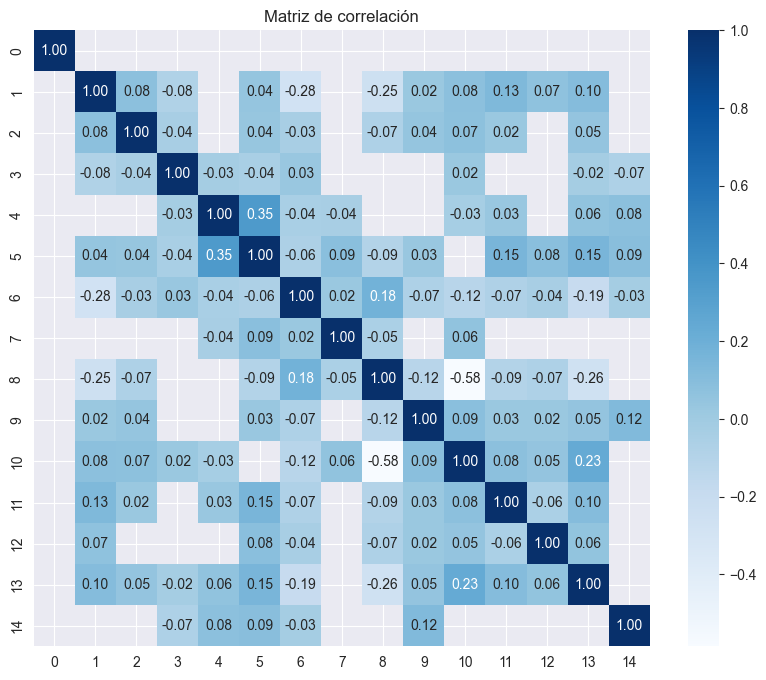

0: age
1: workclass
2: fnlwgt
3: education
4: education-num
5: marital-status
6: occupation
7: relationship
8: race
9: sex
10: capital-gain
11: capital-loss
12: hours-per-week
13: native-country
14: income


In [26]:
import pandas as pd

data, labels = preprocess_data_adult_income(shuffle=False)
data = pd.DataFrame(data)
# Calcula la matriz de correlación
correlation_matrix = data.corr()

# Visualiza la matriz de correlación en forma de mapa de calor
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

data.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

for i in range(len(data.columns)):
    print(f"{i}: {data.columns[i]}")

In [23]:
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np

data, labels = preprocess_data(name="adult_income", shuffle=False)

# Cliente 1
train_data1, labels1 = load_client_data(num_parties=2, client_id=1, data=data, labels=labels)
x_train1, x_test1, y_train1, y_test1 = train_test_split(train_data1, labels1, test_size=0.2, shuffle=False)
x_train1 = x_train1[:, 1:]  # Para que no tengan en cuenta el ID
x_test1 = x_test1[:, 1:]  # Para que no tengan en cuenta el ID

for i in range(1, 8):
    selector = SelectKBest(f_regression, k=i)
    best_train = selector.fit_transform(x_train1, y_train1)
    best_test = selector.transform(x_test1)
    print(f"Características a seleccionar entre {i} candidatos: {np.where(selector.get_support())[0]}")

# 0: age
# 1: workclass
# 2: fnlwgt
# 3: education
# 4: education-num
# 5: marital-status
# 6: occupation

Características a seleccionar entre 1 candidatos: [4]
Características a seleccionar entre 2 candidatos: [ 4 10]
Características a seleccionar entre 3 candidatos: [ 4  7 10]
Características a seleccionar entre 4 candidatos: [ 0  4  7 10]
Características a seleccionar entre 5 candidatos: [ 0  4  7 10 12]
Características a seleccionar entre 6 candidatos: [ 0  4  7  9 10 12]
Características a seleccionar entre 7 candidatos: [ 0  4  5  7  9 10 12]
Características a seleccionar entre 8 candidatos: [ 0  4  5  7  9 10 11 12]
Características a seleccionar entre 9 candidatos: [ 0  4  5  7  8  9 10 11 12]
Características a seleccionar entre 10 candidatos: [ 0  3  4  5  7  8  9 10 11 12]
Características a seleccionar entre 11 candidatos: [ 0  3  4  5  6  7  8  9 10 11 12]
Características a seleccionar entre 12 candidatos: [ 0  1  3  4  5  6  7  8  9 10 11 12]
Características a seleccionar entre 13 candidatos: [ 0  1  3  4  5  6  7  8  9 10 11 12 13]
Características a seleccionar entre 14 candidato

C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

In [4]:
# Cliente 2
train_data2, labels2 = load_client_data(num_parties=2, client_id=2, data=data, labels=labels)
x_train2, x_test2, y_train2, y_test2 = train_test_split(train_data2, labels2, test_size=0.2, shuffle=False)
x_train2 = x_train2[:, 1:]  # Para que no tengan en cuenta el ID
x_test2 = x_test2[:, 1:]  # Para que no tengan en cuenta el ID

for i in range(1, 8):
    selector = SelectKBest(f_regression, k=i)
    best_train = selector.fit_transform(x_train2, y_train2)
    best_test = selector.transform(x_test2)
    print(f"Características a seleccionar entre {i} candidatos: {np.where(selector.get_support())[0]}")

# 0->7: relationship
# 1->8: race
# 2->9: sex
# 3->10: capital-gain
# 4->11: capital-loss
# 5->12: hours-per-week
# 6->13: native-country
# 7->14: income

Características a seleccionar entre 1 candidatos: [3]
Características a seleccionar entre 2 candidatos: [0 3]
Características a seleccionar entre 3 candidatos: [0 3 5]
Características a seleccionar entre 4 candidatos: [0 2 3 5]
Características a seleccionar entre 5 candidatos: [0 2 3 4 5]
Características a seleccionar entre 6 candidatos: [0 1 2 3 4 5]
Características a seleccionar entre 7 candidatos: [0 1 2 3 4 5 6]


C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

In [5]:
# Ver cuantas caracteristicas seleccionar:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.utils.validation import column_or_1d

pipe = Pipeline([('kbest', SelectKBest(f_regression)),
                 ('lineal', LinearRegression())])
grid = GridSearchCV(pipe, {'kbest__k': range(1, 6)}, cv=10)
y_train = column_or_1d(y_train1, warn=True)
grid.fit(x_train1, y_train1)
grid.best_params_

C:\Users\Arturo\AppData\Local\Temp\ipykernel_2540\4017450699.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_train = column_or_1d(y_train1, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

{'kbest__k': 5}

In [ ]:
import shap

shap.initjs()

In [ ]:
def f(x):
    return ensemble.predict([x[:, i] for i in range(x.shape[1])]).flatten()


In [ ]:
explainer = shap.KernelExplainer(f, data.iloc[:50, :])
shap_values = explainer.shap_values(data.iloc[299:, :], nsamples=500)
shap.force_plot(explainer.expected_value, data.iloc[299, :])

## Importancia de las características Breast Cancer

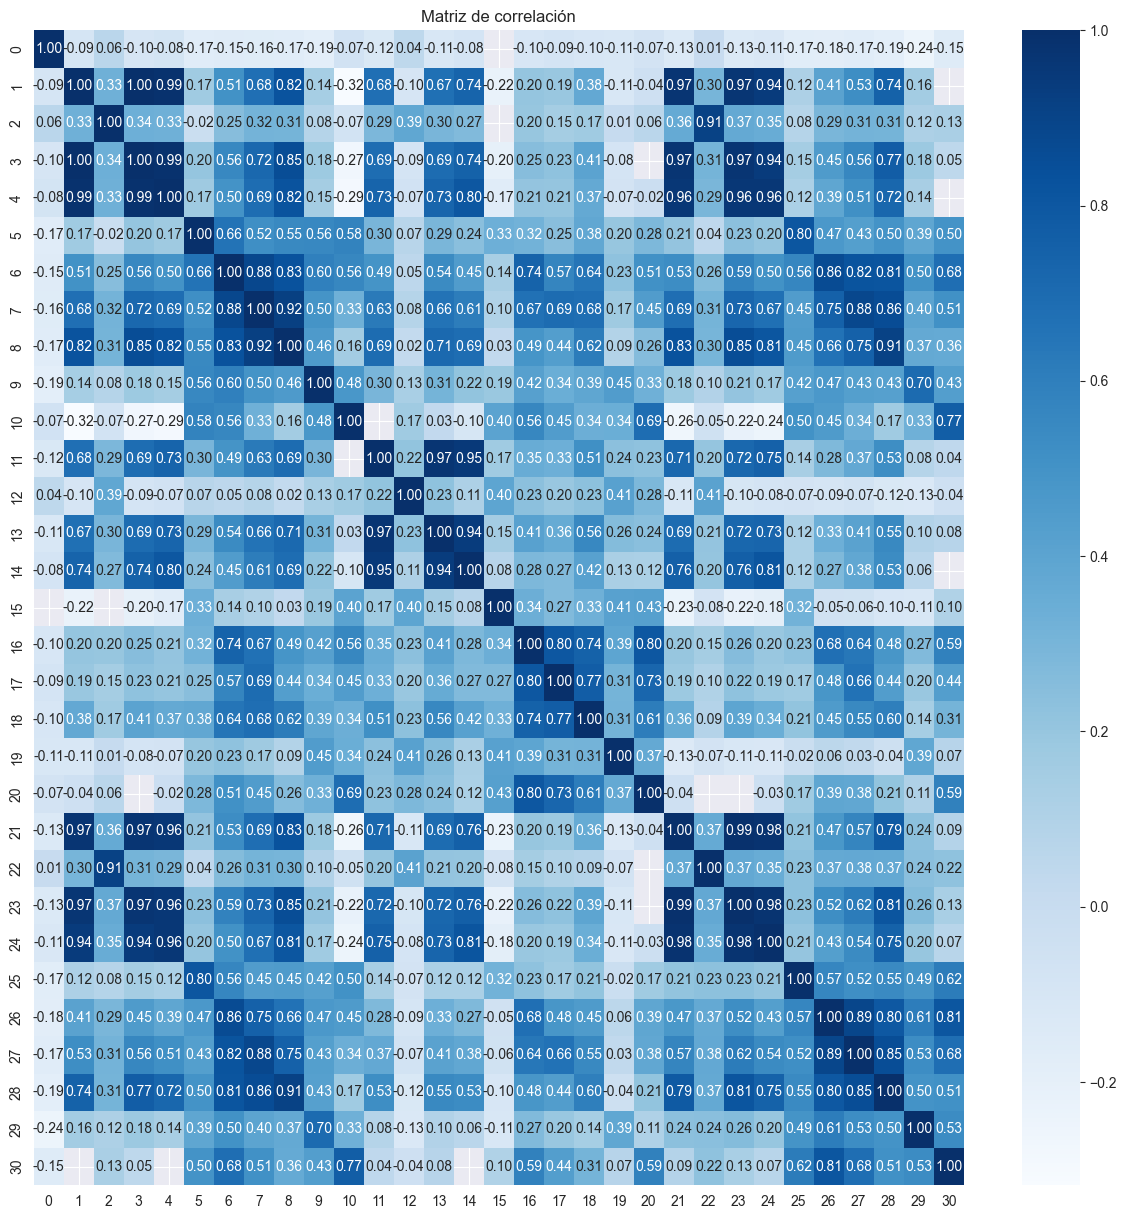

0: diagnosis
1: radius_mean
2: texture_mean
3: perimeter_mean
4: area_mean
5: smoothness_mean
6: compactness_mean
7: concavity_mean
8: concave points_mean
9: symmetry_mean
10: fractal_dimension_mean
11: radius_se
12: texture_se
13: perimeter_se
14: area_se
15: smoothness_se
16: compactness_se
17: concavity_se
18: concave points_se
19: symmetry_se
20: fractal_dimension_se
21: radius_worst
22: texture_worst
23: perimeter_worst
24: area_worst
25: smoothness_worst
26: compactness_worst
27: concavity_worst
28: concave points_worst
29: symmetry_worst
30: fractal_dimension_worst


In [3]:
import pandas as pd

data, labels = preprocess_data_breast_cancer(shuffle=False)
data = pd.DataFrame(data)
# Calcula la matriz de correlación
correlation_matrix = data.corr()

# Visualiza la matriz de correlación en forma de mapa de calor
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix[(correlation_matrix <= -0.01) | (correlation_matrix >= 0.01)], annot=True, cmap="Blues",
            fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

data.columns = ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
                'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean',
                'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
                'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se',
                'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
                'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst',
                'fractal_dimension_worst']

for i in range(len(data.columns)):
    print(f"{i}: {data.columns[i]}")

In [14]:
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np

data, labels = preprocess_data(name="breast_cancer", shuffle=False)

# Cliente 1
train_data1, labels1 = load_client_data(num_parties=2, client_id=1, data=data, labels=labels)
x_train1, x_test1, y_train1, y_test1 = train_test_split(train_data1, labels1, test_size=0.2, shuffle=False)
x_train1 = x_train1[:, 1:]  # Para que no tengan en cuenta el ID
x_test1 = x_test1[:, 1:]  # Para que no tengan en cuenta el ID

for i in range(1, 16):
    selector = SelectKBest(f_regression, k=i)
    best_train = selector.fit_transform(x_train1, y_train1)
    best_test = selector.transform(x_test1)
    print(f"Características a seleccionar entre {i} candidatos: {np.where(selector.get_support())[0]}")

# 0: diagnosis
# 1: radius_mean
# 2: texture_mean
# 3: perimeter_mean
# 4: area_mean
# 5: smoothness_mean
# 6: compactness_mean
# 7: concavity_mean
# 8: concave points_mean
# 9: symmetry_mean
# 10: fractal_dimension_mean
# 11: radius_se
# 12: texture_se
# 13: perimeter_se
# 14: area_se
# 15: smoothness_se

Características a seleccionar entre 1 candidatos: [7]
Características a seleccionar entre 2 candidatos: [2 7]
Características a seleccionar entre 3 candidatos: [0 2 7]
Características a seleccionar entre 4 candidatos: [0 2 3 7]
Características a seleccionar entre 5 candidatos: [0 2 3 6 7]
Características a seleccionar entre 6 candidatos: [0 2 3 5 6 7]
Características a seleccionar entre 7 candidatos: [ 0  2  3  5  6  7 13]
Características a seleccionar entre 8 candidatos: [ 0  2  3  5  6  7 10 13]
Características a seleccionar entre 9 candidatos: [ 0  2  3  5  6  7 10 12 13]
Características a seleccionar entre 10 candidatos: [ 0  1  2  3  5  6  7 10 12 13]
Características a seleccionar entre 11 candidatos: [ 0  1  2  3  4  5  6  7 10 12 13]
Características a seleccionar entre 12 candidatos: [ 0  1  2  3  4  5  6  7  8 10 12 13]
Características a seleccionar entre 13 candidatos: [ 0  1  2  3  4  5  6  7  8 10 12 13 14]
Características a seleccionar entre 14 candidatos: [ 0  1  2  3  4  

C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

In [22]:
# Cliente 2
train_data2, labels2 = load_client_data(num_parties=2, client_id=2, data=data, labels=labels)
x_train2, x_test2, y_train2, y_test2 = train_test_split(train_data2, labels2, test_size=0.2, shuffle=False)
x_train2 = x_train2[:, 1:]  # Para que no tengan en cuenta el ID
x_test2 = x_test2[:, 1:]  # Para que no tengan en cuenta el ID

for i in range(1, 16):
    selector = SelectKBest(f_regression, k=i)
    best_train = selector.fit_transform(x_train2, y_train2)
    best_test = selector.transform(x_test2)
    print(f"Características a seleccionar entre {i} candidatos: {np.where(selector.get_support())[0]}")

# 0 -> 16: compactness_se
# 1 -> 17: concavity_se
# 2 -> 18: concave points_se
# 3 -> 19: symmetry_se
# 4 -> 20: fractal_dimension_se
# 5 -> 21: radius_worst
# 6 -> 22: texture_worst
# 7 -> 23: perimeter_worst
# 8 -> 24: area_worst
# 9 -> 25: smoothness_worst
# 10 -> 26: compactness_worst
# 11 -> 27: concavity_worst
# 12 -> 28: concave points_worst
# 13 -> 29: symmetry_worst
# 14 -> 30: fractal_dimension_worst


Características a seleccionar entre 1 candidatos: [12]
Características a seleccionar entre 2 candidatos: [ 7 12]
Características a seleccionar entre 3 candidatos: [ 5  7 12]
Características a seleccionar entre 4 candidatos: [ 5  7  8 12]
Características a seleccionar entre 5 candidatos: [ 5  7  8 11 12]
Características a seleccionar entre 6 candidatos: [ 5  7  8 10 11 12]
Características a seleccionar entre 7 candidatos: [ 5  6  7  8 10 11 12]
Características a seleccionar entre 8 candidatos: [ 5  6  7  8  9 10 11 12]
Características a seleccionar entre 9 candidatos: [ 5  6  7  8  9 10 11 12 13]
Características a seleccionar entre 10 candidatos: [ 2  5  6  7  8  9 10 11 12 13]
Características a seleccionar entre 11 candidatos: [ 2  5  6  7  8  9 10 11 12 13 14]
Características a seleccionar entre 12 candidatos: [ 0  2  5  6  7  8  9 10 11 12 13 14]
Características a seleccionar entre 13 candidatos: [ 0  1  2  5  6  7  8  9 10 11 12 13 14]
Características a seleccionar entre 14 candidat

C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Arturo\anaconda3\envs\tfm\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple